# M6A Analysis Part 4

This part will take the high-confidence peaks and intersect with the genomic annotations.

Prerequisites:
 - get all peaks from CLAM m6A snakemake pipeline
 - intersect high-confidence peaks (`$group.peaks.bed`) from M6A_Analysis.Part3
 - parsed genomic annotation files using R library `GenomicFeatures` (can be found in `create_regions.R` in CLAM_ENCODE_Snakemake)

In [1]:
# A few global configurations
GENOME = 'mm10'
PEAK_DIR = '../_data/m6A/high_conf_peaks/'
SAVE_FIG = True

## Intersect high-confidence peaks with region annotations

The intersection function was modified from a script in CLAM ENCODE eCLIP Snakemake pipeline.

In [2]:
# use this function for intersection in the backend
from scripts.intersect_regions import intersect_gtf_regions
help(intersect_gtf_regions)

Help on function intersect_gtf_regions in module scripts.intersect_regions:

intersect_gtf_regions(peak_fp, outfn, gtf_dir, do_plot=False)
    function: intersect_gtf_regions(peak_fp, outfn, gtf_dir, [do_plot=False])
    Intersect a peak BED file with a list of genomic region annotations (e.g. start/stop codon, UTR, intron), 
    output the intersection counts and peak-region annotations.
    :param peak_fp: filepath to a BED-format peak
    :param outfn: filepath to output count file, has to end with ".txt"; annotation will be "NNN.annot.txt"
    :param do_plot: plot the bar-chart, optional
    :rtype: pd.DataFrame, the count for each region annotation.
    .. example::
                    category        count   norm_count
                    0       start   593     0.246556
                    1       stop    1606    0.720184
                    2       3UTR    6737    0.006684
                    3       5UTR    2375    0.011469



In [3]:
import os
peak_fn_list = [os.path.join(PEAK_DIR, x) for x in os.listdir(PEAK_DIR) if x.endswith('bed')]
df_dict = {}
for peak_fn in peak_fn_list:
    group = peak_fn.split('/')[-1].split('.')[0]
    count_df = intersect_gtf_regions(peak_fn, '../_data/m6A/high_conf_peaks/{}_region.txt'.format(group), '../_data/GTF/mm10/')
    group = peak_fn.split('/')[-1].rstrip('.peaks.bed')
    df_dict[group] = count_df

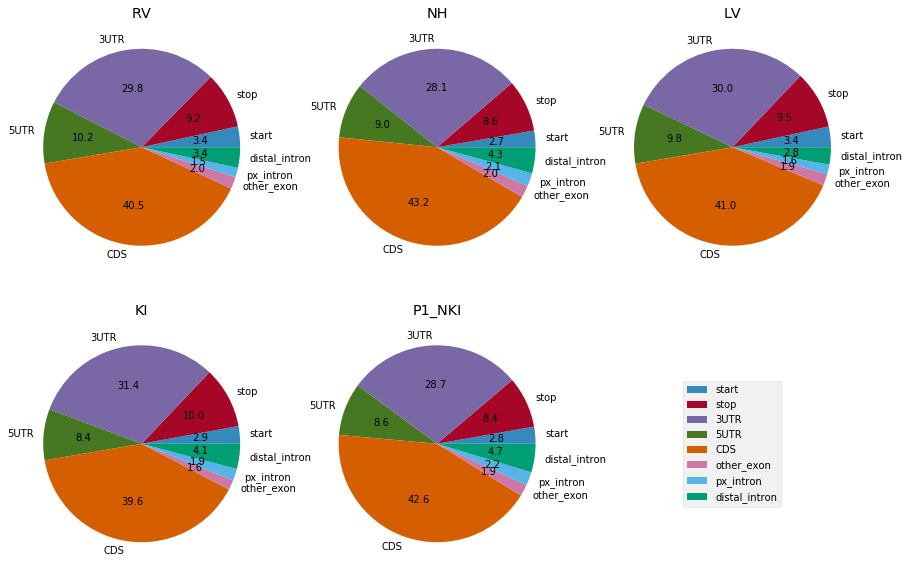

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
#print(plt.style.available)
plt.style.use('bmh')
i=0; j=0
fig, axes = plt.subplots(2,3, figsize=(15,10))
for group in df_dict:
    count_df = df_dict[group]
    count_df.plot.pie(y="count", autopct="%.1f", labels=count_df.category, title=group, ax=axes[i,j], legend=False)
    axes[i,j].set(ylabel='', aspect='equal')
    j += 1
    if j>2:
        i+=1
        j=0
axes[1,2].axis('off')
handles, labels = axes[1,1].get_legend_handles_labels()
axes[1,2].legend(handles, labels, loc='center')

if SAVE_FIG:
    plt.savefig('region_distr.pdf')

## Write an updated Table with Region Annotation [optional]

Read in the peaks and update the Excel file from `Part_03` of this set of analyses.

In [23]:
# use pandas to read in an Excel with multiple sheets
import pandas as pd
reader = pd.ExcelFile(open("../20181019-m6A-3/M6A_Peaks.xlsx","rb"))
writer = pd.ExcelWriter('M6A_Peaks.wRegionAnnot.xlsx', engine='xlsxwriter')
print(reader.sheet_names)

['LV', 'RV', 'NH', 'KI', 'P1_NKI']


In [24]:
#sheet_name='LV'
for sheet_name in reader.sheet_names:
    base_sheet = pd.read_excel(reader, sheet_name)
    regAnnot = pd.read_table(os.path.join(PEAK_DIR, '{}_region.annot.txt'.format(sheet_name)), header=None)
    regAnnot.index = regAnnot.apply(lambda x: "{}:{}-{}:{}".format(x[0], x[1], x[2], x[4]), 1 )
    base_sheet['RegAnnot'] = pd.Series(
        [ regAnnot.loc[x, 5] if x in regAnnot.index else '#NA' for x in base_sheet.index], 
        index=base_sheet.index) 
    # fix the `url` column as that seems not readable by pandas
    base_sheet['locus'] = pd.Series([ x[:-2] for x in base_sheet.index], index=base_sheet.index)
    base_sheet.to_excel(writer, sheet_name=sheet_name)
writer.save()

In [25]:
base_sheet.head()

,gene,strand,replicate,ratio,num_replicates,url,geneSymbol,RegAnnot,locus
chr10:100096030-100096130:+,ENSMUSG00000019966,+,"P1_NKI_4,P1_NKI_12,P1_NKI_1,P1_NKI_3,P1_NKI_6","2.39,2.92,3.14,2.93,2.29",5,0,Kitl,3UTR,chr10:100096030-100096130
chr10:100096130-100096230:+,ENSMUSG00000019966,+,"P1_NKI_7,P1_NKI_4,P1_NKI_12,P1_NKI_8,P1_NKI_1,...","3.58,2.92,3.33,3.02,3.15,2.39,1.95,3.83,1.92,2...",12,0,Kitl,3UTR,chr10:100096130-100096230
chr10:100096230-100096330:+,ENSMUSG00000019966,+,"P1_NKI_7,P1_NKI_4,P1_NKI_12,P1_NKI_1,P1_NKI_5,...","1.63,1.98,1.75,1.69,1.78,1.79,1.80,2.11,2.48,1.70",10,0,Kitl,3UTR,chr10:100096230-100096330
chr10:100096330-100096430:+,ENSMUSG00000019966,+,"P1_NKI_4,P1_NKI_12,P1_NKI_8,P1_NKI_1,P1_NKI_5,...","2.64,2.60,2.20,1.88,2.31,2.07,3.12,1.72,1.70,2.58",10,0,Kitl,3UTR,chr10:100096330-100096430
chr10:100096430-100096530:+,ENSMUSG00000019966,+,"P1_NKI_7,P1_NKI_4,P1_NKI_12,P1_NKI_8,P1_NKI_1,...","2.39,2.72,2.63,1.95,1.64,1.86,1.85,2.21,2.40,2...",11,0,Kitl,3UTR,chr10:100096430-100096530
